In [40]:
from Bio.PDB import *

import Bio.PDB as bpdb
from Bio.PDB.PDBIO import PDBIO
from Bio.PDB.DSSP import DSSP
from Bio.PDB.DSSP import dssp_dict_from_pdb_file
from Bio import SeqIO
from Bio import SearchIO
from Bio.SeqUtils import seq1
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq

import pickle
import os
from os import path
from os.path import isfile, join, dirname, isdir, exists

import gudhi as gd
from scipy.optimize import minimize_scalar, least_squares

from IPython.display import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy.linalg as linalg
from scipy import sparse
import scipy.signal
from scipy.optimize import minimize
from scipy.ndimage import gaussian_filter1d
import sys
import math


def make_dir(*argv):
    mydir = path.join(*argv)    
    if not path.exists(mydir):        
        if len(argv) > 1:
            make_dir(*argv[:-1])            
        os.mkdir(mydir)
    return mydir


def make_path(*argv):
    mypath = path.join(*argv)
    if not path.exists(dirname(mypath)):
        make_dir(*argv[:-1])
    return mypath

def get_fasta_record(file, seqid):
    with open(file) as handle:
        for record in SeqIO.parse(handle, "fasta"):
            if record.id == seqid:
                return record
        raise Exception('did not find sequence')
    
def avgper(motifs):    
    diff = [second - first for first, second in zip(motifs, motifs[1:])]
    return int(np.mean(diff))

In [41]:
with open('pickles/uniprot_d.pickle', 'rb') as handle:
    uniprot_d = pickle.load(handle)
with open('pickles/nlrome_matches_d.pickle', 'rb') as handle:
    matches_d = pickle.load(handle)
with open('pickles/nlrome_motifs_d.pickle', 'rb') as handle:
    motifs_d = pickle.load(handle)
with open('pickles/nlrome_matches_d.pickle', 'rb') as handle:
    matches_d = pickle.load(handle)    
with open('pickles/LRR_hmm_d.pickle', 'rb') as handle:
    LRR_hmm_d = pickle.load(handle)    


In [42]:
if False:
    LRR_hmm_d = {}

    ethresh = 1e-5 ### adjust this for e-value threshold

    hmmmsearch_domout_path = make_path('hmmsearch_dom', 'athaliana.txt')

    qresult = next(SearchIO.parse(hmmmsearch_domout_path, 'hmmsearch3-domtab'))
    filtered_hits = list(filter(lambda hsp: hsp.evalue < ethresh, qresult.hsps))
    hit_ids = [hsp.hit_id for hsp in filtered_hits]
    with open(make_path('protein', 'col-hmm-LRR.fa'), "w") as output_handle:
        for tairid, uniid in uniprot_d.items():
            #     hit_sequences = sorted([record for record in prot_l if record.id in hit_ids], key=lambda a: hit_ids.index(a.id))
            #     print('\n'.join([f'E-value: {filtered_hits[ii].evalue} for ' + hit_sequences[ii].description for ii in range(numTop)]))

            found = False
            ends_l = []
            evalue_l = []
            for hsp in filtered_hits:                
                if hsp.hit_id == "ATHALIANA_%s"%tairid.replace('.','_'):
                    ends_l.append(hsp.env_end)
                    evalue_l.append(-np.log(hsp.evalue))
                    found = True
            if found:
                if len(ends_l)>1:          
                    hitrank = sorted(zip(ends_l,evalue_l), key=lambda tup: tup[1], reverse = True)
                    hitrank_filt = [tup for tup in hitrank if hitrank[0][1] - tup[1]<3]
                    cutoff = min(hitrank_filt, key=lambda tup: tup[1])[0]
                    if len(hitrank_filt)>1:
                        print('multiple nb-arc hits', tairid, hitrank_filt, cutoff)          
                elif len(ends_l) == 1:
                    cutoff = ends_l[0]
                    hitrank_filt = zip(ends_l, evalue_l)
                else:
                    raise Exception('no nbarc found')
                record = get_fasta_record(make_path('protein', 'corr.Athaliana.protein.fasta'), "ATHALIANA_%s"%tairid.replace('.','_'))
                record = record[cutoff:]
                record.id += '|%d'%cutoff
                record.description = '|'.join(["%d_%d"%(tup[0],int(tup[1])) for tup in hitrank_filt])
                SeqIO.write(record, output_handle, "fasta")
                LRR_hmm_d[tairid] = cutoff
            else:
                print('record ', record.id, 'nb-arc domain not found')

            if True:
                parser = PDBParser()
                structure = parser.get_structure(uniid, 'afdb/%s.pdb'%uniid)

                chain = list(structure.get_chains())[0]

                class ResSelect(bpdb.Select):
                    def accept_residue(self, res):
                        if res.id[1] >= cutoff:
                            return True
                        else:
                            return False            
                io = bpdb.PDBIO()       
                io.set_structure(chain)
                io.save(make_path('pdb', 'nlrome_LRR-hmm','%s.pdb'%tairid), ResSelect())                

    with open('pickles/LRR_hmm_d.pickle', 'wb') as handle:
        pickle.dump(LRR_hmm_d, handle)            

In [3]:
# prot_l = []
# id_l = []

# for record in SeqIO.parse(make_path('protein', 'corr.Athaliana.protein.fasta'), "fasta"):
#     prot_l.append(record)
#     id_l.append(record.id)        


# LRR_l = []
# ethresh = 1e-7 ### adjust this for e-value threshold

# hmmmsearch_domout_path = make_path('hmmsearch_dom', 'athaliana.txt')

# qresult = next(SearchIO.parse(hmmmsearch_domout_path, 'hmmsearch3-domtab'))
# filtered_hits = list(filter(lambda hsp: hsp.evalue < ethresh, qresult.hsps))
# hit_ids = [hsp.hit_id for hsp in filtered_hits]
# #     hit_sequences = sorted([record for record in prot_l if record.id in hit_ids], key=lambda a: hit_ids.index(a.id))
# #     print('\n'.join([f'E-value: {filtered_hits[ii].evalue} for ' + hit_sequences[ii].description for ii in range(numTop)]))
# with open(make_path('protein', 'col-hmm-LRR.fa'), "w") as output_handle:
#     for record in prot_l:
#         found = False
#         ends_l = []
#         evalue_l = []
#         for hsp in filtered_hits:                
#             if hsp.hit_id == record.id:
#                 ends_l.append(hsp.env_end)
#                 evalue_l.append(-np.log(hsp.evalue))
#                 found = True
#         if found:
#             if len(ends_l)>1:
#                 print('multiple nb-arc hits', ends_l, record.id)                    
#                 hitrank = sorted(zip(ends_l,evalue_l), key=lambda tup: tup[1], reverse = True)
#                 hitrank_filt = [tup for tup in hitrank if hitrank[0][1] - tup[1]<3]
#                 cutoff = min(hitrank_filt, key=lambda tup: tup[0])[0]
#                 print('filtered', hitrank_filt, cutoff)
#             elif len(ends_l) == 1:
#                 cutoff = ends_l[0]
#             else:
#                 raise Exception('no nbarc found')
#             record = record[cutoff:]
#             record.id += '|%d'%cutoff
#             record.description = '|'.join([str(_) for _ in ends_l])
#             SeqIO.write(record, output_handle, "fasta")
#             LRR_l.append(record)
#         else:
#             print('record ', record.id, 'nb-arc domain not found')

multiple nb-arc hits [425, 626] ATHALIANA_AT5G48780_2
filtered [(626, 42.180500848973026)] 626
multiple nb-arc hits [339, 472] ATHALIANA_AT1G63860_1
filtered [(339, 19.624653548278303)] 339
record  ATHALIANA_AT1G72940_1 nb-arc domain not found
multiple nb-arc hits [426, 998] ATHALIANA_AT4G19500_1
filtered [(998, 45.869380303086956)] 998
record  ATHALIANA_AT1G72910_1 nb-arc domain not found
multiple nb-arc hits [496, 1742] ATHALIANA_AT3G25510_1
filtered [(496, 55.53647907755886)] 496
record  ATHALIANA_AT5G66890_1 nb-arc domain not found
record  ATHALIANA_AT1G17615_1 nb-arc domain not found
multiple nb-arc hits [425, 667] ATHALIANA_AT5G48780_1
filtered [(667, 52.266309958303104)] 667
multiple nb-arc hits [432, 899] ATHALIANA_AT4G36140_1
filtered [(899, 55.16673205205277)] 899
multiple nb-arc hits [339, 472] ATHALIANA_AT1G63860_2
filtered [(339, 19.658555099953983)] 339


In [13]:
if False:

    tairid = 'AT3G44480.1'
    for record in LRR_l:
        if '.'.join(record.id.split('|')[0].split('_')[1:]) == tairid:
            LRRStart = int(record.description)
            break

In [20]:
# import Bio.PDB as bpdb

# for tairid, uniid in uniprot_d.items():

#     parser = PDBParser()
#     structure = parser.get_structure(uniid, 'afdb/%s.pdb'%uniid)

#     chain = list(structure.get_chains())[0]

#     io = bpdb.PDBIO()        

#     io.set_structure(chain)
#     io.save(make_path('pdb', 'nlrome_whole','%s.pdb'%tairid))

In [29]:
# for tairid, uniid in uniprot_d.items():    
#     for record in LRR_l:
#         if '.'.join(record.id.split('|')[0].split('_')[1:]) == tairid:
#             start_res = int(record.description.split('|')[0])
#             break    
#     parser = PDBParser()
#     structure = parser.get_structure(uniid, 'afdb/%s.pdb'%uniid)

#     chain = list(structure.get_chains())[0]

#     class ResSelect(bpdb.Select):
#         def accept_residue(self, res):
#             if res.id[1] >= start_res:
#                 return True
#             else:
#                 return False
            
#     io = bpdb.PDBIO()       

#     io.set_structure(chain)
#     io.save(make_path('pdb', 'nlrome_LRR-hmm','%s.pdb'%tairid), ResSelect())

In [ ]:
# for (tairid, uniid), motifs in motifs_d.items():
#     start_res, end_res=motifs[0],motifs[-1]

#     parser = PDBParser()
#     structure = parser.get_structure(uniid, 'afdb/%s.pdb'%uniid)

#     chain = list(structure.get_chains())[0]

#     class ResSelect(bpdb.Select):
#         def accept_residue(self, res):
#             if res.id[1] >= start_res and res.id[1] <= end_res:
#                 return True
#             else:
#                 return False
            
#     io = bpdb.PDBIO()        

#     io.set_structure(chain)
#     io.save(make_path('pdb', 'nlrome_LRR','%s.pdb'%uniid), ResSelect())

In [52]:
LRR_hmm_d

{'AT5G45050.1': 464,
 'AT1G10920.1': 385,
 'AT5G38350.1': 334,
 'AT1G12290.2': 447,
 'AT1G50180.1': 513,
 'AT1G58400.1': 499,
 'AT5G44510.1': 522,
 'AT1G17600.1': 492,
 'AT3G07040.1': 514,
 'AT3G50950.1': 498,
 'AT5G41740.2': 490,
 'AT5G51630.2': 396,
 'AT1G61310.1': 495,
 'AT3G44480.1': 587,
 'AT1G56520.2': 501,
 'AT1G15890.1': 484,
 'AT4G16920.1': 483,
 'AT1G72840.1': 454,
 'AT4G09430.1': 445,
 'AT4G12020.1': 1069,
 'AT3G44670.2': 580,
 'AT1G10920.2': 385,
 'AT1G12210.1': 487,
 'AT5G45200.1': 509,
 'AT1G12290.1': 489,
 'AT4G16960.1': 493,
 'AT5G43470.2': 503,
 'AT5G66910.1': 499,
 'AT4G19520.1': 463,
 'AT1G57650.2': 237,
 'AT5G48620.1': 503,
 'AT5G18370.1': 541,
 'AT4G36140.1': 899,
 'AT5G49140.1': 471,
 'AT5G47260.1': 474,
 'AT3G51570.1': 542,
 'AT1G56520.1': 502,
 'AT5G40060.1': 317,
 'AT1G63730.1': 455,
 'AT4G16950.2': 514,
 'AT5G46470.1': 506,
 'AT3G46530.1': 499,
 'AT5G40910.1': 470,
 'AT3G44630.2': 600,
 'AT1G12220.2': 488,
 'AT3G50950.2': 498,
 'AT1G65850.1': 515,
 'AT5G47250.

In [53]:
if False:
    for tairid in uniprot_d.keys():
        parser = PDBParser()
        structure = parser.get_structure(tairid, 'pdb/nlrome_LRR-hmm/%s.pdb'%tairid)
        chain = list(structure.get_chains())[0]

        alpha_carbons=[]

        for ii, residue in enumerate(chain.get_residues()):    
            if residue.get_full_id()[3][1] >= LRR_hmm_d[tairid]:
                alpha_carbons.append(np.array(list(residue["CA"].get_vector())))
            else:
                raise Exception()

        X = np.array(alpha_carbons)
        X.shape

        windowSize = 25

        totpers_l=[]
        for windowStart in range(X.shape[0]- windowSize-1):
            Y = X[windowStart:windowStart+windowSize,:]
            stree = gd.AlphaComplex(points = Y).create_simplex_tree()
            dgm = stree.persistence()
            dgm1_lens = [d-b for (dim, (b, d)) in dgm if dim == 1]
            dgmstat = sum(dgm1_lens)
            # gd.plot_persistence_diagram(dgm, legend = True)
            totpers_l.append(dgmstat)
        np.save(make_path('npy', 'totpers', '%s.npy'%tairid), np.array(totpers_l))

            # break            

In [43]:
totpers_d = {}
for tairid in uniprot_d.keys():
    totpers_d[tairid] = np.load(make_path('npy', 'totpers', '%s.npy'%tairid))
        

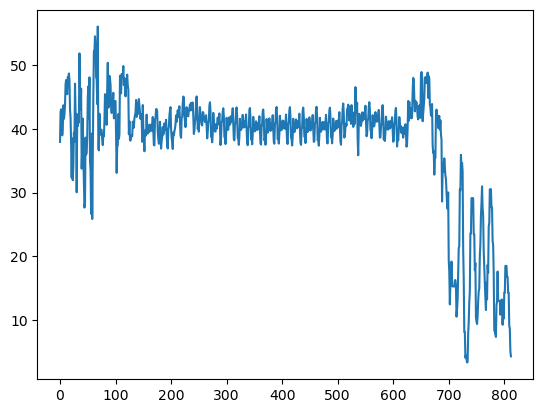

In [55]:
plt.plot(totpers_d['AT1G69550.1'])

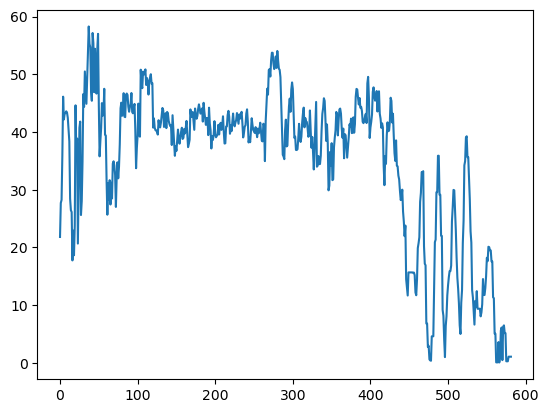

In [6]:
plt.plot(totpers_d['AT3G44480.1'])

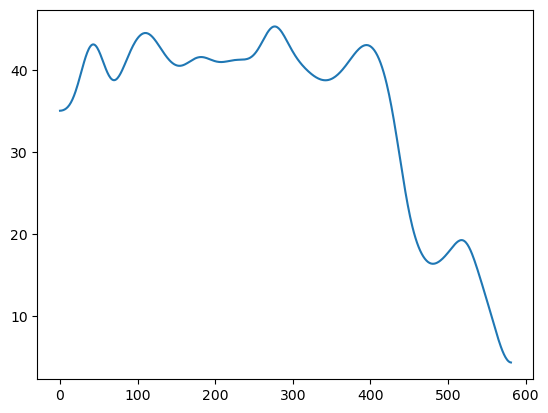

In [5]:
swtp = gaussian_filter1d(totpers_d['AT3G44480.1'], 15)

plt.plot(swtp)

In [39]:


# def f(x):
#     return np.array([swtp[ii] - 40 if ii<x[0] else swtp[ii] for ii in range(swtp.shape[0]) ])
# res_1 = least_squares(f, [300])


# res_1.x

array([300.00000473])

In [44]:

def get_conf(tairid):
    parser = PDBParser()
    structure = parser.get_structure(tairid, 'pdb/nlrome_LRR-hmm/%s.pdb'%tairid)
    chain = list(structure.get_chains())[0]
    return [residue['CA'].get_bfactor() for residue in chain.get_residues()]


In [46]:
from matplotlib.collections import LineCollection

for tairid, swtp in totpers_d.items():
    # g = gaussian_filter1d(swtp, 15)
    # if tairid !=  'AT5G44510.1':
    #     continue
    g = swtp

    # g = g-np.min(g)
    # g = g/np.quantile(g, .95)

    N= g.shape[0]

    mins = []
    argmins = []
    for h in range(int(np.max(g))):
        def f(x):
            return np.sum(np.array([g[ii] - h if ii < x else g[ii]/2 for ii in range(N)])**2)
        res = minimize_scalar(f, bounds = (0, N), method='bounded')
        mins.append(res.fun)
        argmins.append(int(res.x))

    h = np.argmin(mins)
    b = argmins[h]
    print(h,b)

    x = np.arange(N)
    y = g
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    conf = np.array(get_conf(tairid)[:N])
    # print(len(conf))

    fig, axs = plt.subplots(1, 1, sharex=True, sharey=True)
    
    norm = plt.Normalize(conf.min(), conf.max())
    lc = LineCollection(segments, cmap='viridis', norm=norm)
    # Set the values used for colormapping
    lc.set_array(conf)
    lc.set_linewidth(2)
    line = axs.add_collection(lc)
    fig.colorbar(line, ax=axs)    

    # plt.plot(g)
    plt.axhline(h, color = 'r')
    plt.axvline(b, color = 'r')

    plt.savefig(make_path('plots','swtp', '%s.png'%tairid))
    plt.close()


39 488


In [34]:
conf = get_conf(tairid)

In [35]:
len(conf)

639

In [36]:
N

221

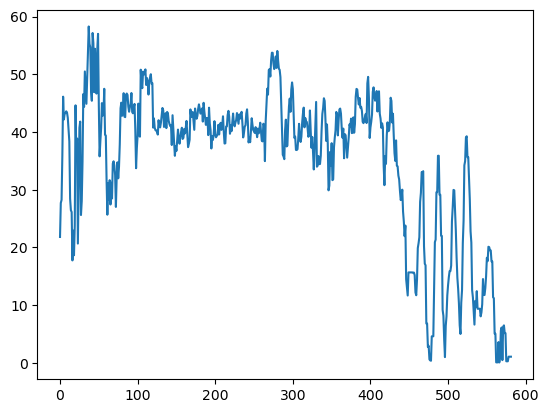

In [11]:
plt.plot(x, y)

0 247


FileNotFoundError: [Errno 2] No such file or directory: 'swtp/AT5G45050.1.png'

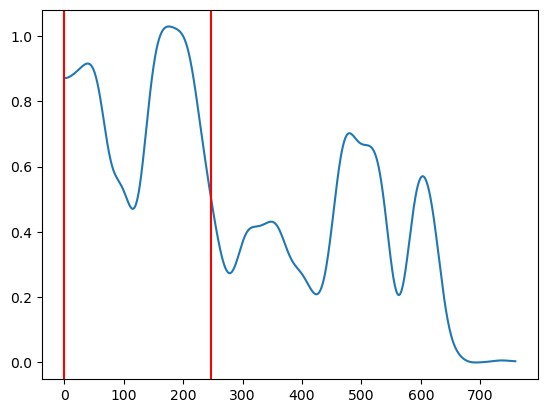

In [40]:
g = gaussian_filter1d(swtp, 15)
g = g-np.min(g)

g = g/np.quantile(g, .95)
N= g.shape[0]

mins = []
argmins = []
for a in range(int(.2*N)):
    def f(x):
        return np.sum(np.array([g[ii] - 1 if a < ii < x else g[ii] for ii in range(N)])**2)
    res = minimize_scalar(f, bounds = (a, N), method='bounded')
    mins.append(res.fun)
    argmins.append(int(res.x))

a = np.argmin(mins)
b = argmins[a]
print(a,b)

plt.plot(g)
plt.axvline(a, color = 'r')
plt.axvline(b, color = 'r')
plt.savefig(make_path('plots','swtp', '%s.png'%tairid))
plt.close()

In [37]:
argmins

[671,
 671,
 671,
 671,
 671,
 671,
 671,
 670,
 670,
 670,
 671,
 671,
 670,
 670,
 670,
 671,
 671,
 671,
 671,
 671,
 671,
 670,
 671,
 671,
 671,
 671,
 671,
 670,
 670,
 671,
 670,
 671,
 671,
 671,
 671,
 670,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 670,
 670,
 670,
 671,
 671,
 670,
 671,
 671,
 671,
 671,
 671,
 671,
 670,
 671,
 671,
 671,
 670,
 671,
 671,
 671,
 671,
 670,
 671,
 671,
 671,
 671,
 670,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 684,
 671,
 670,
 685,
 671,
 671,
 670,
 670,
 671,
 670,
 670,
 671,
 671,
 670,
 671,
 671,
 670,
 670,
 670,
 670,
 671,
 671,
 671,
 671,
 670,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 672,
 671,
 671,
 671,
 672,
 671,
 671,
 671,
 670,
 693,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 670,
 671,
 671,
 671,
 670,
 671,
 671]

0 671


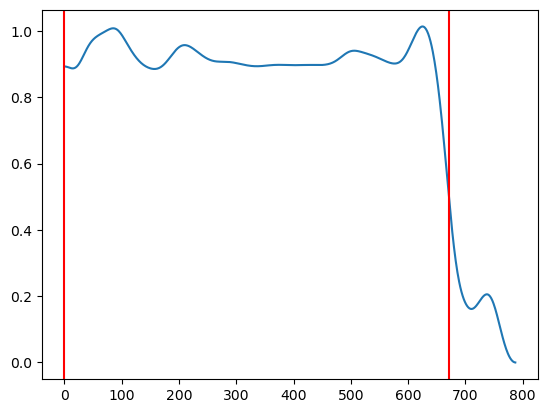

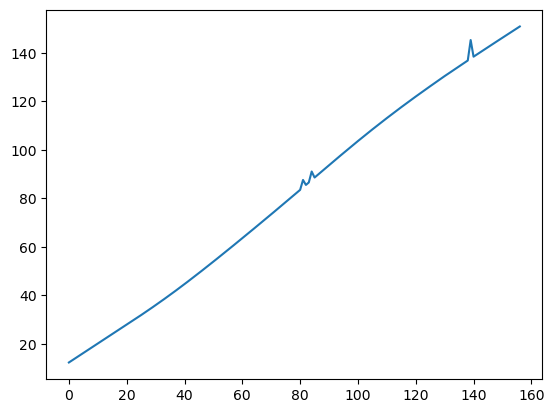

In [35]:
plt.plot(mins)

[400.00000881]


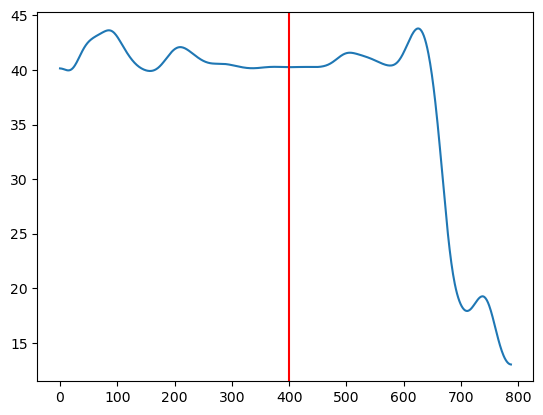

In [11]:
from scipy.optimize import minimize

swtp = gaussian_filter1d(totpers_d['AT1G69550.1'], 15)

def f(x):
    return np.sum(np.array([swtp[ii] - 40 if ii<x[0] else swtp[ii] for ii in range(swtp.shape[0])])**2)

res_1 = minimize(f, [400], bounds = [(0, len(swtp))])

a = res_1.x[0]
print(res_1.x)
plt.plot(swtp)
plt.axvline(a, color = 'r')

In [54]:
def f(x):
    return np.sum(np.array([swtp[ii] - 40 if ii<x else swtp[ii] for ii in range(swtp.shape[0])])**2)

res = minimize_scalar(f, bounds = (0, len(swtp)), method='bounded')

     fun: 48098.04667267787
 message: 'Solution found.'
    nfev: 28
     nit: 28
  status: 0
 success: True
       x: 675.5420087357162

In [38]:
f(400)

TypeError: unsupported operand type(s) for ** or pow(): 'list' and 'int'

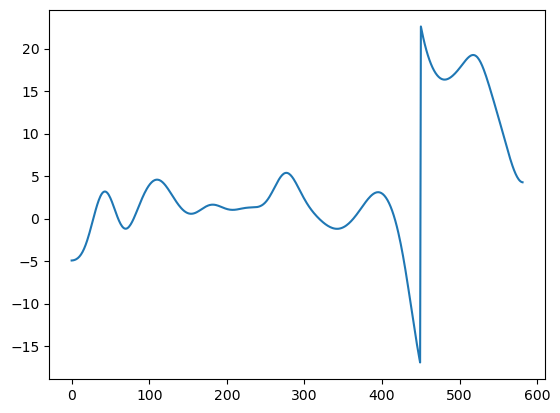

In [31]:
plt.plot(f([450]))

array([150.00000908,  40.95152643])

In [71]:
f([0, 450, 40])

[-4.925948949596467,
 -4.919270893073801,
 -4.90556810527589,
 -4.884575160531554,
 -4.855585046199721,
 -4.81797237659022,
 -4.770831506008982,
 -4.713187927518959,
 -4.64393230318916,
 -4.561991051209205,
 -4.466330626705606,
 -4.35587104015503,
 -4.229498366356154,
 -4.086183818455289,
 -3.9252591356731017,
 -3.746158609631941,
 -3.5483905946213383,
 -3.33193123979526,
 -3.096839849238876,
 -2.8435010231064837,
 -2.572811814979133,
 -2.2858641986536483,
 -1.9839840073170194,
 -1.6689713764529728,
 -1.342779395441596,
 -1.0077150108667325,
 -0.6663988881211509,
 -0.3217087970281014,
 0.02333514134971182,
 0.36564368566891403,
 0.7019012464210874,
 1.0288990953081694,
 1.343296353905572,
 1.6417753933719226,
 1.921108833454653,
 2.1785059991966875,
 2.4112934790433442,
 2.616965772071879,
 2.793147655563459,
 2.9383133380041784,
 3.0509828687300313,
 3.1304324330441915,
 3.1759010897321645,
 3.18727025108209,
 3.1650906595019066,
 3.109987028146058,
 3.0233049800198657,
 2.90674585703

In [38]:
windowSize = 25

print(windowSize)
totpers_l=[]
for windowStart in range(X.shape[0]- windowSize-1):
    Y = X[windowStart:windowStart+windowSize,:]
    stree = gd.AlphaComplex(points = Y).create_simplex_tree()
    dgm = stree.persistence()
    dgm1_lens = [d-b for (dim, (b, d)) in dgm if dim == 1]
    dgmstat = sum(dgm1_lens)
    # gd.plot_persistence_diagram(dgm, legend = True)
    totpers_l.append(dgmstat)
    print(windowStart, dgmstat)


    # break

25
0 21.80826486451479
1 27.699855001932498
2 28.226313006093704
3 35.89810109518932
4 46.120190680879375
5 42.16835854107928
6 43.21129829061274
7 43.27977569807347
8 43.58245086584389
9 43.37820381861611
10 42.46569412201304
11 40.33818338551249
12 38.37531240929629
13 28.441762071575777
14 26.442654440289843
15 26.12483595570041
16 17.743820772739586
17 22.913805595233224
18 18.639813950194625
19 23.824066852183734
20 44.620252556202736
21 35.95059485210354
22 38.873754155186056
23 20.663892864977637
24 31.225739367587863
25 40.72621140101489
26 41.800981173588895
27 25.60767476046262
28 28.04497833185551
29 34.873337505550026
30 46.574334229463716
31 44.36231854052792
32 50.4916719696099
33 47.75037062994221
34 44.88434565504913
35 49.16729008381289
36 53.41032889035283
37 58.286798759241975
38 55.24742391976227
39 54.70932491082473
40 47.105121710648305
41 45.412442256537105
42 57.15801802692992
43 55.36289285411404
44 46.896930892808825
45 54.427082236508255
46 50.94499419095585


In [36]:
np.save('npy/totpers_%s.npy'%tairid, totpers_l)

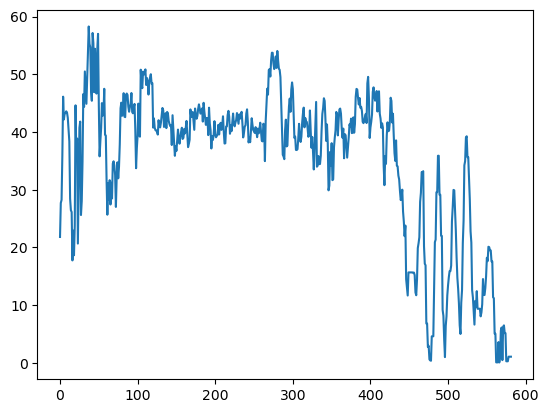

In [35]:
plt.plot(totpers_l)

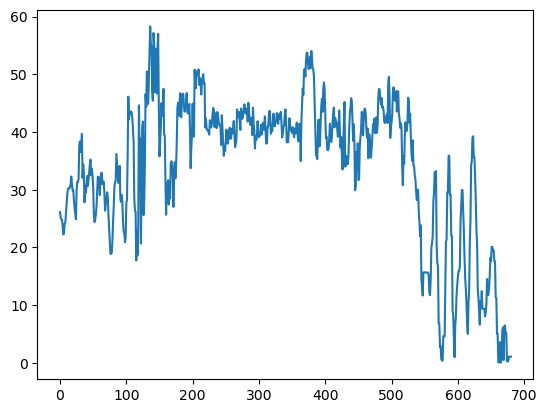

In [58]:
plt.plot(totpers_l)